**Load Dataset**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)

# Display dataset information
print("Dataset Information:\n", data.info())
print("\nFirst Few Rows of the Dataset:\n", data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
Dataset Information:
 None

First Few Rows of the Dataset:
      Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


**Exploratory Data Analysis**


---


In [3]:
# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Rename columns for clarity
data.rename(columns={"Passengers": "Passenger_Count"}, inplace=True)
print(data.head())


            Passenger_Count
Month                      
1949-01-01              112
1949-02-01              118
1949-03-01              132
1949-04-01              129
1949-05-01              121


Monthly Airline Passenger Traffic

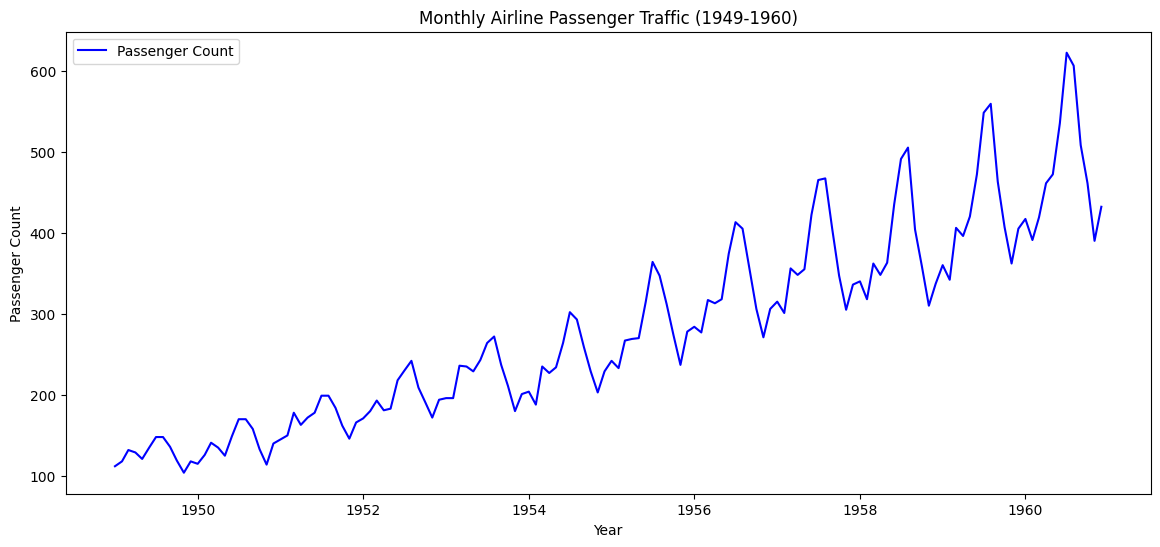

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(data, color="blue", label="Passenger Count")
plt.title("Monthly Airline Passenger Traffic (1949-1960)")
plt.xlabel("Year")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()


Seasonal Decomposition

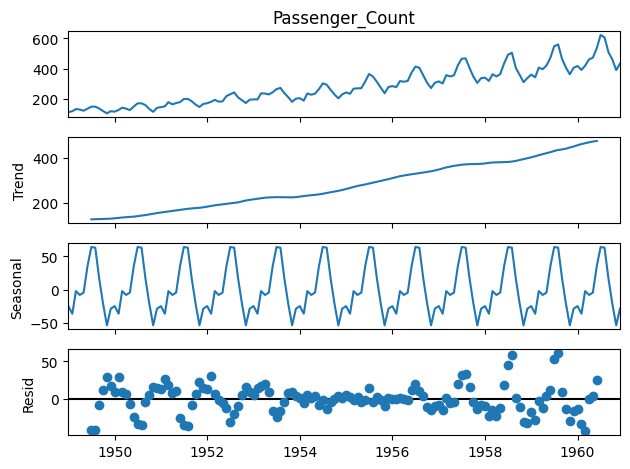

In [5]:
# Decompose the time series
decomposition = seasonal_decompose(data['Passenger_Count'], model='additive', period=12)
decomposition.plot()
plt.show()


Distribution of Passenger Counts

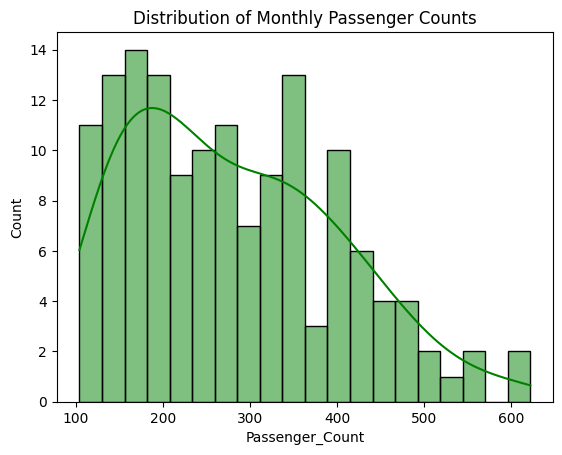

In [6]:
sns.histplot(data['Passenger_Count'], kde=True, color="green", bins=20)
plt.title("Distribution of Monthly Passenger Counts")
plt.show()


Rolling Averages and Variance

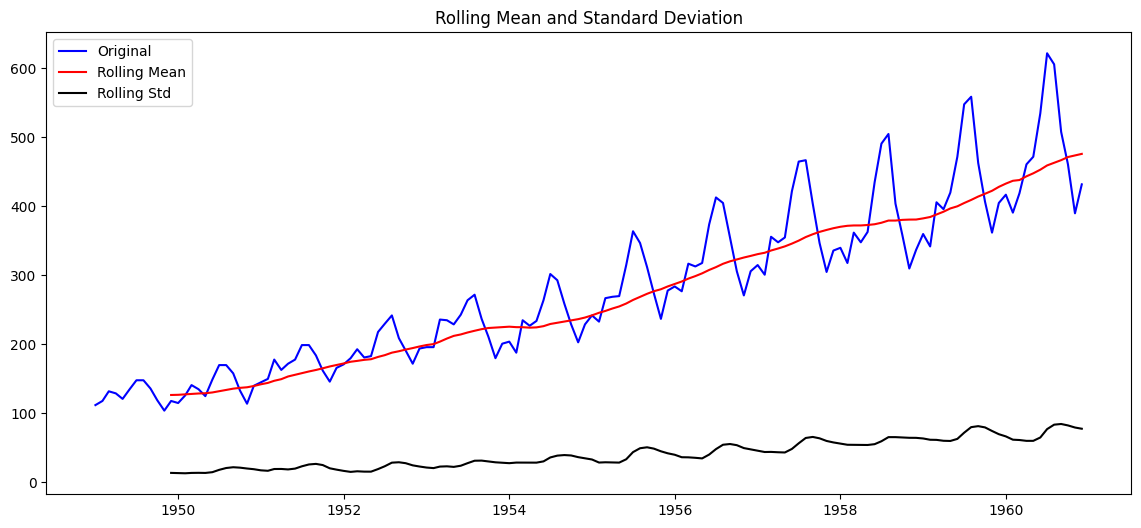

In [7]:
# Calculate rolling mean and standard deviation
rolling_mean = data['Passenger_Count'].rolling(window=12).mean()
rolling_std = data['Passenger_Count'].rolling(window=12).std()

plt.figure(figsize=(14, 6))
plt.plot(data['Passenger_Count'], label="Original", color="blue")
plt.plot(rolling_mean, label="Rolling Mean", color="red")
plt.plot(rolling_std, label="Rolling Std", color="black")
plt.legend()
plt.title("Rolling Mean and Standard Deviation")
plt.show()


**Machine Learning Models**


---

Data Preprocessing

In [9]:
# Extract year and month as features
data['Year'] = data.index.year
data['Month'] = data.index.month

# Lag features
data['Lag_1'] = data['Passenger_Count'].shift(1)
data['Lag_2'] = data['Passenger_Count'].shift(2)
data.dropna(inplace=True)

# Features and target
X = data[['Year', 'Month', 'Lag_1', 'Lag_2']]
y = data['Passenger_Count']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model Training


Linear Regression

In [10]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
predictions_lr = lr.predict(X_test_scaled)

# Evaluate Linear Regression
print("Linear Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, predictions_lr):.2f}")
print(f"MSE: {mean_squared_error(y_test, predictions_lr):.2f}")
print(f"R2 Score: {r2_score(y_test, predictions_lr):.2f}")


Linear Regression Performance:
MAE: 20.21
MSE: 669.87
R2 Score: 0.95


Random Forest Regressor with Hyperparameter Tuning

In [11]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
rf.fit(X_train_scaled, y_train)

print(f"Best Parameters: {rf.best_params_}")
best_rf = rf.best_estimator_

# Evaluate Random Forest
predictions_rf = best_rf.predict(X_test_scaled)
print("Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, predictions_rf):.2f}")
print(f"MSE: {mean_squared_error(y_test, predictions_rf):.2f}")
print(f"R2 Score: {r2_score(y_test, predictions_rf):.2f}")


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Performance:
MAE: 22.73
MSE: 773.54
R2 Score: 0.94


**Forecasting**

In [12]:
# Use the last year for testing
train = data['Passenger_Count'][:-12]
test = data['Passenger_Count'][-12:]


Exponential Smoothing

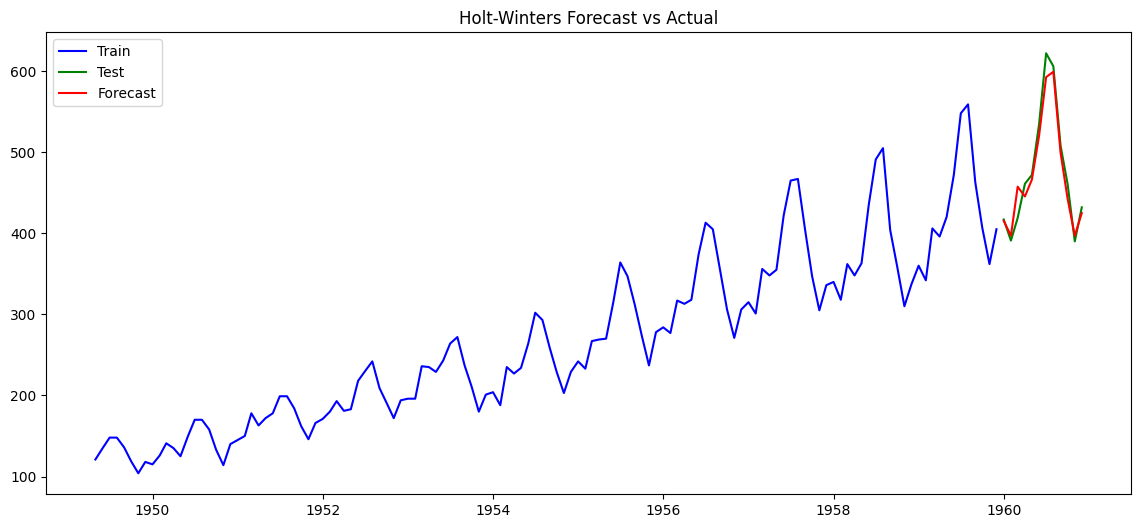

In [13]:
# Apply Holt-Winters method
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
forecast = fit.forecast(len(test))

# Plot observed and forecasted values
plt.figure(figsize=(14, 6))
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="green")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title("Holt-Winters Forecast vs Actual")
plt.show()


In [14]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)

print("Forecast Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")


Forecast Evaluation:
MAE: 13.25
MSE: 284.87
R2 Score: 0.95
